# Physics-Informed Neural Networks for 1D Heat Equation

This notebook demonstrates the implementation of a Physics-Informed Neural Network (PINN) to solve the 1D heat equation and compares it with the analytical and a simple numerical solutions.

> <font color='red'>Word of Caution: Training PINNs is computationally intensive and may take a significant amount of time depending on the hardware used. Running this notebook on a M1 MacBook Pro M3 with 18GB takes almost 10 minutes. So please be patient while the model trains. All the other cells before and after the training cell should run almost instantly. The training cell is the section "5. Physics-Informed Neural Network (PINN)".</font>

## Problem Description

We solve the 1D heat equation on a rod with Dirichlet boundary conditions:

**PDE:** $$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$$

**Boundary Conditions:**
- $u(0, t) = T_L$ (left bath)
- $u(L, t) = T_R$ (right bath)

**Initial Condition:**
- $u(x, 0) = u_0$ (constant initial temperature)

### Physical Parameters
- Rod length: $L = 1.0$ m
- Left bath: $T_L = 100°C$
- Right bath: $T_R = 0°C$
- Initial temperature: $u_0 = -20°C$
- Material: Copper with thermal diffusivity $\alpha = 1.11 \times 10^{-4}$ m²/s

### Problem Setup and Nondimensionalization

To simplify the problem, we use dimensionless variables:

**Dimensionless variables:**
- $\tilde{x} = x/L$
- $\tilde{t} = t\alpha/L^2$
- $\tilde{u} = (u - T_R)/(T_L - T_R)$

The dimensionless heat equation becomes:
$$\frac{\partial \tilde{u}}{\partial \tilde{t}} = \frac{\partial^2 \tilde{u}}{\partial \tilde{x}^2}$$

with boundary conditions:
- $\tilde{u}(0, \tilde{t}) = 1$
- $\tilde{u}(1, \tilde{t}) = 0$

### Import Required Libraries and Initializing Python Variables

In [23]:
import time
from tqdm.notebook import tqdm

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax


In [24]:
# Problem parameters (physical)
L = 1.0  # meters
T_L_phys = 100.0  # left bath, degC
T_R_phys = 0.0  # right bath, degC
u0_phys_value = -20.0  # initial rod temperature, degC

# thermal diffusivity (example: copper)
alpha_phys = 1.11e-4  # m^2/s

# nondimensionalization for temperature: map T_R -> 0, T_L -> 1
T_scale = T_L_phys - T_R_phys
T_L = 1.0
T_R = 0.0
u0_dim = (u0_phys_value - T_R_phys) / T_scale  # should be -0.2

print(f"Dimensionless initial temp u0_dim = {u0_dim}")

# characteristic time
tau = L**2 / alpha_phys
print(f"Characteristic time tau = {tau:.1f} s (~{tau / 3600:.2f} hours)")

# we'll simulate dimensionless time up to t_max (dimensionless)
# pick a physical horizon, e.g., 1 hour -> dimensionless
t_phys_max = 3600.0  # seconds
t_max = t_phys_max / tau
print(f"Simulate up to t_phys = {t_phys_max}s -> t_dim = {t_max:.4f}")

Dimensionless initial temp u0_dim = -0.2
Characteristic time tau = 9009.0 s (~2.50 hours)
Simulate up to t_phys = 3600.0s -> t_dim = 0.3996


## 3. Analytical Solution

The analytical solution consists of a steady-state part and a transient part:

$$u(x,t) = u_s(x) + \sum_{n=1}^{\infty} B_n \sin\left(\frac{n\pi x}{L}\right) \exp\left(-\alpha \left(\frac{n\pi}{L}\right)^2 t\right)$$

where:
- $u_s(x) = T_L + (T_R - T_L)\frac{x}{L}$ is the steady-state solution
- $B_n$ are Fourier coefficients determined by the initial condition

In dimensionless form:
$$\tilde{u}(\tilde{x},\tilde{t}) = (1-\tilde{x}) + \sum_{n=1}^{\infty} B_n \sin(n\pi \tilde{x}) \exp(-n^2\pi^2 \tilde{t})$$

In [25]:
def compute_Bn_coeffs_linear(a, b, N_terms):
    """
    Compute Fourier coefficients for initial deviation v0(x) = a + b*x on [0,1]

    For v0(x) = a + b*x, the Fourier sine series coefficients are:
    B_n = 2 * ∫₀¹ (a + b*x) sin(nπx) dx

    After integration:
    ∫₀¹ a sin(nπx) dx = a * (1 - (-1)^n) / (nπ)
    ∫₀¹ x sin(nπx) dx = -(-1)^n / (nπ)

    So: B_n = 2 * [ a * (1 - (-1)^n) / (nπ) - b * (-1)^n / (nπ) ]
    """
    n = jnp.arange(1, N_terms + 1)
    # Coefficient for constant term a
    coeff_a = 2.0 * a * (1 - (-1.0) ** n) / (n * jnp.pi)
    # Coefficient for linear term b*x (note the minus sign!)
    coeff_b = -2.0 * b * ((-1.0) ** n) / (n * jnp.pi)
    B = coeff_a + coeff_b
    return B


# define v0(x) coefficients a + b x for our example
# v0(x) = u0_dim - u_s_dim(x) = u0_dim - (1 - x) = (u0_dim - 1) + x
a = u0_dim - 1.0
b = 1.0

# compute and inspect a few coefficients
N_terms = 50
B = compute_Bn_coeffs_linear(a, b, N_terms)
print("First 8 B_n:", np.array(B[:8]))

First 8 B_n: [-0.8912677  -0.31830987 -0.29708922 -0.15915494 -0.17825353 -0.10610329
 -0.12732396 -0.07957747]


In [26]:
def analytical_u_dim(x, t, N_terms=200, alpha=1.0, Ldim=1.0):
    """
    Evaluate analytical solution (dimensionless) at arrays x and t
    """
    # x, t can be numpy arrays; convert to jnp
    x = jnp.asarray(x)
    t = jnp.asarray(t)
    # steady linear profile in dimensionless variables
    u_s = 1.0 - x / Ldim

    # prepare series
    n = jnp.arange(1, N_terms + 1)
    Bn = compute_Bn_coeffs_linear(a, b, N_terms)

    # compute sin(n pi x) for all n and x using vmap
    def series_at_x(xi, ti):
        exponents = jnp.exp(-alpha * (n * jnp.pi / Ldim) ** 2 * ti)
        s = jnp.sum(Bn * jnp.sin(n * jnp.pi * xi / Ldim) * exponents)
        return s

    # support broadcasting: if x is 1D and t is 1D, produce grid
    if x.ndim == 1 and t.ndim == 1:
        # Use broadcasting directly with the series computation
        # x[:, None] has shape (nx, 1), t[None, :] has shape (1, nt)
        x_expanded = x[:, None]  # shape (nx, 1)
        t_expanded = t[None, :]  # shape (1, nt)

        # Compute series using broadcasting
        exponents = jnp.exp(
            -alpha * (n[:, None, None] * jnp.pi / Ldim) ** 2 * t_expanded
        )  # shape (N_terms, nx, nt)
        sin_terms = jnp.sin(
            n[:, None, None] * jnp.pi * x_expanded / Ldim
        )  # shape (N_terms, nx, nt)
        S = jnp.sum(
            Bn[:, None, None] * sin_terms * exponents, axis=0
        )  # sum over N_terms, result shape (nx, nt)

        u_s_grid = 1.0 - x_expanded  # shape (nx, 1), broadcasts to (nx, nt)
        return u_s_grid + S
    else:
        # fallback: elementwise evaluate with same shape
        series_vmap = jax.vmap(series_at_x, in_axes=(0, 0))
        return u_s + series_vmap(x, t)


analytical_u_dim = jax.jit(analytical_u_dim, static_argnames=["N_terms"])

### Visualize Analytical Solution

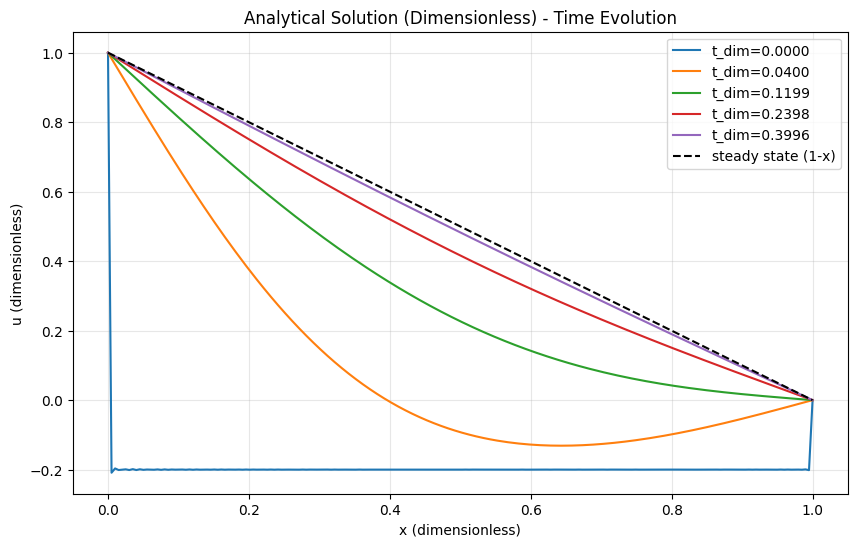

In [27]:
# Plot analytical solution snapshots
x_grid = np.linspace(0.0, 1.0, 200)
times = np.array([0.0, t_max * 0.1, t_max * 0.3, t_max * 0.6, t_max])
U_analytic = analytical_u_dim(x_grid, times, N_terms=5000)

plt.figure(figsize=(10, 6))
for i, tt in enumerate(times):
    plt.plot(x_grid, np.array(U_analytic)[:, i], label=f"t_dim={tt:.4f}")
plt.plot(x_grid, 1 - x_grid, "k--", label="steady state (1-x)")
plt.xlabel("x (dimensionless)")
plt.ylabel("u (dimensionless)")
plt.legend()
plt.title("Analytical Solution (Dimensionless) - Time Evolution")
plt.grid(True, alpha=0.3)
plt.show()

## 4. Numerical Solution - Forward Euler Method

Before we proceed with the PINN approach, let's implement a simple numerical solution using the Forward Euler method (explicit finite difference scheme) to solve the heat equation. This will provide another reference solution to compare against.

The Forward Euler discretization of the heat equation is:

$$\frac{u_i^{n+1} - u_i^n}{\Delta t} = \alpha \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{(\Delta x)^2}$$

Rearranging:
$$u_i^{n+1} = u_i^n + r(u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$

where $r = \frac{\alpha \Delta t}{(\Delta x)^2}$ is the stability parameter. For stability, we need $r \leq 0.5$.

In [28]:
def forward_euler_1d_heat(
    nx, nt, T_final, alpha=1.0, L=1.0, u_init=0.0, u_left=0.0, u_right=1.0
):
    """
    Solve 1D heat equation using Forward Euler method

    Parameters:
    -----------
    nx : int
        Number of spatial grid points
    nt : int
        Number of time steps
    T_final : float
        Final time (dimensionless)
    alpha : float
        Thermal diffusivity (dimensionless, default=1.0)
    L : float
        Domain length (dimensionless, default=1.0)
    u_init : float
        Initial temperature (dimensionless)
    u_left : float
        Left boundary temperature (dimensionless)
    u_right : float
        Right boundary temperature (dimensionless)

    Returns:
    --------
    x : numpy.ndarray
        Spatial grid
    t : numpy.ndarray
        Time grid
    U : numpy.ndarray
        Temperature solution (nx, nt+1)
    r : float
        Stability parameter
    """
    # Create spatial and temporal grids
    dx = L / (nx - 1)
    dt = T_final / nt
    x = np.linspace(0, L, nx)
    t = np.linspace(0, T_final, nt + 1)

    # Stability parameter
    r = alpha * dt / (dx**2)

    # Check stability condition
    if r > 0.5:
        print(f"Warning: Stability condition violated! r = {r:.4f} > 0.5")
        print("Solution may become unstable.")
    else:
        print(f"Stability condition satisfied: r = {r:.4f} ≤ 0.5")

    # Initialize solution array
    U = np.zeros((nx, nt + 1))

    # Set initial condition
    U[:, 0] = u_init

    # Set boundary conditions for all times
    U[0, :] = u_left  # Left boundary
    U[-1, :] = u_right  # Right boundary

    # Time stepping using Forward Euler
    for n in tqdm(range(nt)):
        for i in range(1, nx - 1):  # Interior points only
            U[i, n + 1] = U[i, n] + r * (U[i + 1, n] - 2 * U[i, n] + U[i - 1, n])

    return x, t, U, r


# Test the Forward Euler implementation
print("=== Forward Euler Solution ===")
nx_euler = 201  # Number of spatial points
nt_euler = 1000  # Number of time steps
T_final_euler = t_max  # Use same final time as analytical solution

# Solve using Forward Euler
x_euler, t_euler, U_euler, r_stability = forward_euler_1d_heat(
    nx=nx_euler,
    nt=nt_euler,
    T_final=T_final_euler,
    alpha=1.0,  # Dimensionless thermal diffusivity
    L=1.0,  # Dimensionless length
    u_init=0.0,  # Initial temperature (dimensionless)
    u_left=0.0,  # Left boundary (dimensionless)
    u_right=1.0,  # Right boundary (dimensionless)
)

print(f"Grid size: {nx_euler} × {nt_euler + 1}")
print(f"Spatial resolution: Δx = {x_euler[1] - x_euler[0]:.4f}")
print(f"Temporal resolution: Δt = {t_euler[1] - t_euler[0]:.6f}")
print(f"Stability parameter: r = {r_stability:.4f}")

=== Forward Euler Solution ===
Solution may become unstable.


  0%|          | 0/1000 [00:00<?, ?it/s]

Grid size: 201 × 1001
Spatial resolution: Δx = 0.0050
Temporal resolution: Δt = 0.000400
Stability parameter: r = 15.9840


/var/folders/_2/63g8y8g568q958hmd9yxr2mc0000gp/T/ipykernel_44385/3795031504.py:66: RuntimeWarning: overflow encountered in scalar multiply
  U[i, n + 1] = U[i, n] + r * (U[i + 1, n] - 2 * U[i, n] + U[i - 1, n])
/var/folders/_2/63g8y8g568q958hmd9yxr2mc0000gp/T/ipykernel_44385/3795031504.py:66: RuntimeWarning: overflow encountered in scalar add
  U[i, n + 1] = U[i, n] + r * (U[i + 1, n] - 2 * U[i, n] + U[i - 1, n])
/var/folders/_2/63g8y8g568q958hmd9yxr2mc0000gp/T/ipykernel_44385/3795031504.py:66: RuntimeWarning: overflow encountered in scalar subtract
  U[i, n + 1] = U[i, n] + r * (U[i + 1, n] - 2 * U[i, n] + U[i - 1, n])
/var/folders/_2/63g8y8g568q958hmd9yxr2mc0000gp/T/ipykernel_44385/3795031504.py:66: RuntimeWarning: invalid value encountered in scalar add
  U[i, n + 1] = U[i, n] + r * (U[i + 1, n] - 2 * U[i, n] + U[i - 1, n])


In [29]:
# Recalculate with stable parameters
# For stability r ≤ 0.5, we need dt ≤ 0.5 * dx^2 / alpha
dx_euler = 1.0 / (nx_euler - 1)
dt_stable = 0.4 * dx_euler**2 / 1.0  # Use r = 0.4 for safety
nt_stable = int(T_final_euler / dt_stable) + 1

print("\nRecalculating with stable parameters:")
print(f"Required dt ≤ {0.5 * dx_euler**2:.6f} for stability")
print(f"Using dt = {dt_stable:.6f} (r = 0.4)")
print(f"This requires {nt_stable} time steps")

# Solve with stable parameters and CORRECT boundary/initial conditions
x_euler, t_euler, U_euler, r_stability = forward_euler_1d_heat(
    nx=nx_euler,
    nt=nt_stable,
    T_final=T_final_euler,
    alpha=1.0,  # Dimensionless thermal diffusivity
    L=1.0,  # Dimensionless length
    u_init=u0_dim,  # Correct initial condition: -0.2
    u_left=T_L,  # Left boundary: 1.0
    u_right=T_R,  # Right boundary: 0.0
)

print("\nFinal solution:")
print(f"Grid size: {nx_euler} × {nt_stable + 1}")
print(f"Total time steps: {nt_stable}")
print(f"Computational time range: [0, {t_euler[-1]:.4f}]")


Recalculating with stable parameters:
Required dt ≤ 0.000013 for stability
Using dt = 0.000010 (r = 0.4)
This requires 39961 time steps
Stability condition satisfied: r = 0.4000 ≤ 0.5


  0%|          | 0/39961 [00:00<?, ?it/s]


Final solution:
Grid size: 201 × 39962
Total time steps: 39961
Computational time range: [0, 0.3996]


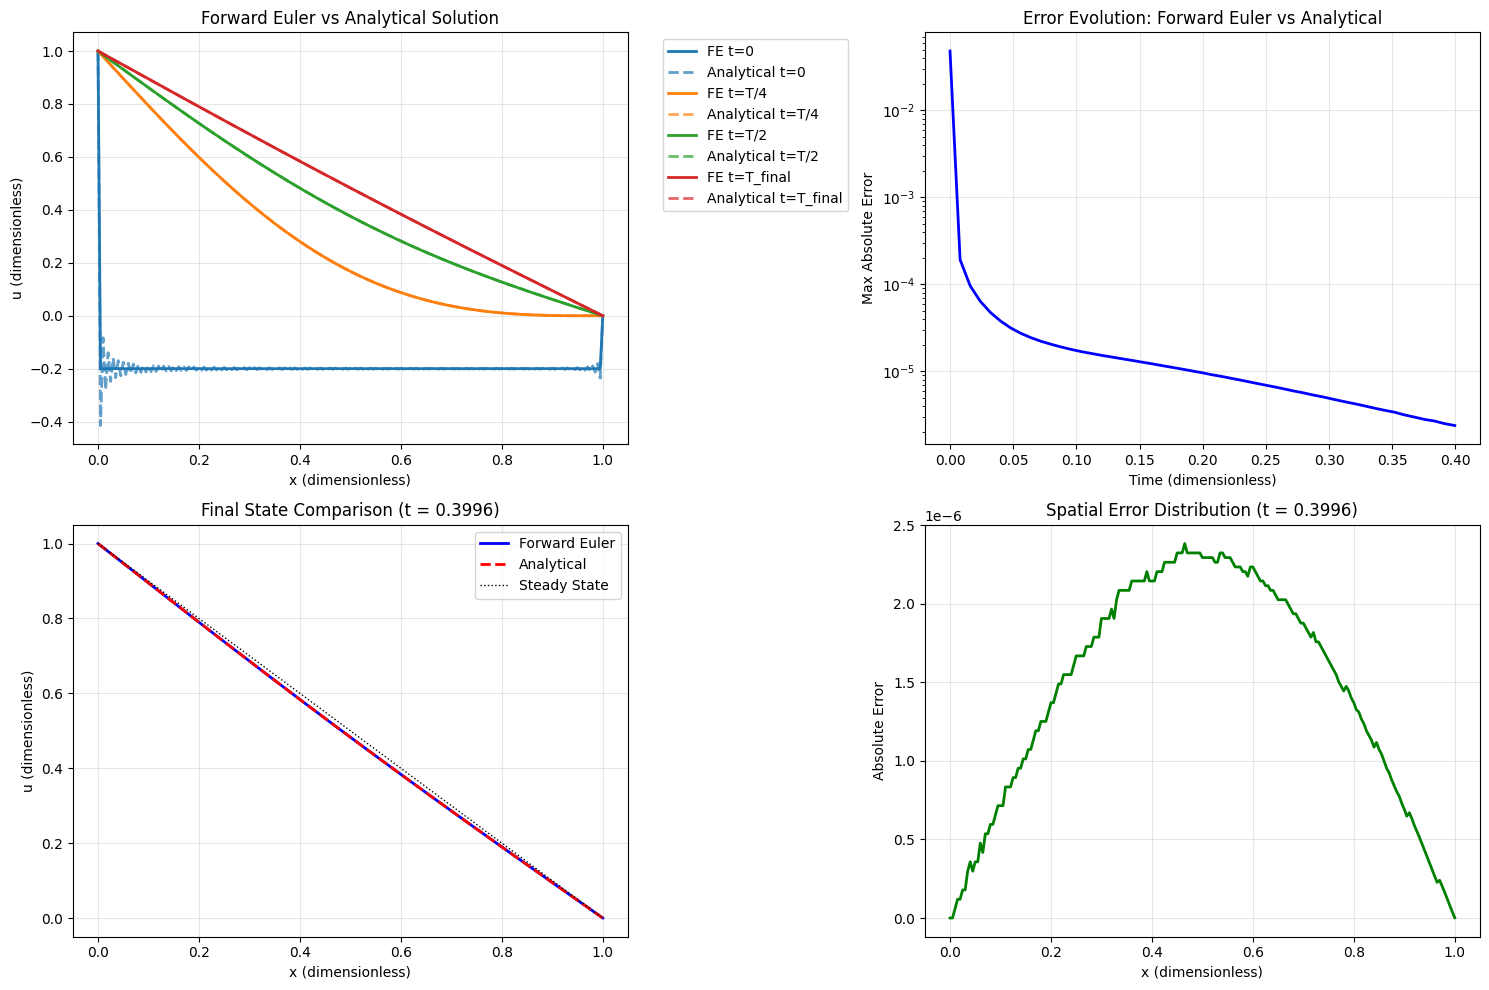


=== Forward Euler Error Analysis ===
Final time: t = 0.3996
Maximum absolute error: 0.000002
RMS error: 0.000002
Relative RMS error: 0.0002%


In [30]:
# Compare Forward Euler with Analytical Solution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Select time indices for comparison
time_indices_euler = [0, len(t_euler) // 4, len(t_euler) // 2, -1]
time_labels = ["t=0", "t=T/4", "t=T/2", "t=T_final"]

# Plot 1: Solution snapshots comparison
ax = axes[0, 0]
for i, (idx, label) in enumerate(zip(time_indices_euler, time_labels)):
    t_val = t_euler[idx]
    # Forward Euler solution
    ax.plot(
        x_euler, U_euler[:, idx], "-", linewidth=2, color=f"C{i}", label=f"FE {label}"
    )
    # Analytical solution at same time
    U_anal_snap = analytical_u_dim(x_euler, np.array([t_val]), N_terms=200).flatten()
    ax.plot(
        x_euler,
        U_anal_snap,
        "--",
        linewidth=2,
        color=f"C{i}",
        alpha=0.7,
        label=f"Analytical {label}",
    )

ax.set_xlabel("x (dimensionless)")
ax.set_ylabel("u (dimensionless)")
ax.set_title("Forward Euler vs Analytical Solution")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(True, alpha=0.3)

# Plot 2: Error evolution over time
ax = axes[0, 1]
errors_over_time = []
for i in range(
    0, len(t_euler), max(1, len(t_euler) // 50)
):  # Sample every few time steps
    t_val = t_euler[i]
    U_anal_snap = analytical_u_dim(x_euler, np.array([t_val]), N_terms=500).flatten()
    error = np.abs(U_euler[:, i] - U_anal_snap)
    errors_over_time.append(np.max(error))

time_sample = t_euler[:: max(1, len(t_euler) // 50)][: len(errors_over_time)]
ax.semilogy(time_sample, errors_over_time, "b-", linewidth=2)
ax.set_xlabel("Time (dimensionless)")
ax.set_ylabel("Max Absolute Error")
ax.set_title("Error Evolution: Forward Euler vs Analytical")
ax.grid(True, alpha=0.3)

# Plot 3: Final state comparison
ax = axes[1, 0]
ax.plot(x_euler, U_euler[:, -1], "b-", linewidth=2, label="Forward Euler")
U_anal_final = analytical_u_dim(x_euler, np.array([t_euler[-1]]), N_terms=500).flatten()
ax.plot(x_euler, U_anal_final, "r--", linewidth=2, label="Analytical")
ax.plot(x_euler, 1 - x_euler, "k:", linewidth=1, label="Steady State")
ax.set_xlabel("x (dimensionless)")
ax.set_ylabel("u (dimensionless)")
ax.set_title(f"Final State Comparison (t = {t_euler[-1]:.4f})")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Error distribution at final time
ax = axes[1, 1]
final_error = np.abs(U_euler[:, -1] - U_anal_final)
ax.plot(x_euler, final_error, "g-", linewidth=2)
ax.set_xlabel("x (dimensionless)")
ax.set_ylabel("Absolute Error")
ax.set_title(f"Spatial Error Distribution (t = {t_euler[-1]:.4f})")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print error statistics
max_error = np.max(final_error)
rms_error = np.sqrt(np.mean(final_error**2))
print("\n=== Forward Euler Error Analysis ===")
print(f"Final time: t = {t_euler[-1]:.4f}")
print(f"Maximum absolute error: {max_error:.6f}")
print(f"RMS error: {rms_error:.6f}")
print(f"Relative RMS error: {rms_error / np.max(U_anal_final) * 100:.4f}%")

### Stability Analysis

The Forward Euler method has a stability restriction: $r = \frac{\alpha \Delta t}{(\Delta x)^2} \leq 0.5$. Let's demonstrate what happens when this condition is violated:

Stability condition satisfied: r = 0.2516 ≤ 0.5


  0%|          | 0/159 [00:00<?, ?it/s]

Solution may become unstable.


  0%|          | 0/79 [00:00<?, ?it/s]

Solution may become unstable.


  0%|          | 0/66 [00:00<?, ?it/s]

Solution may become unstable.


  0%|          | 0/39 [00:00<?, ?it/s]

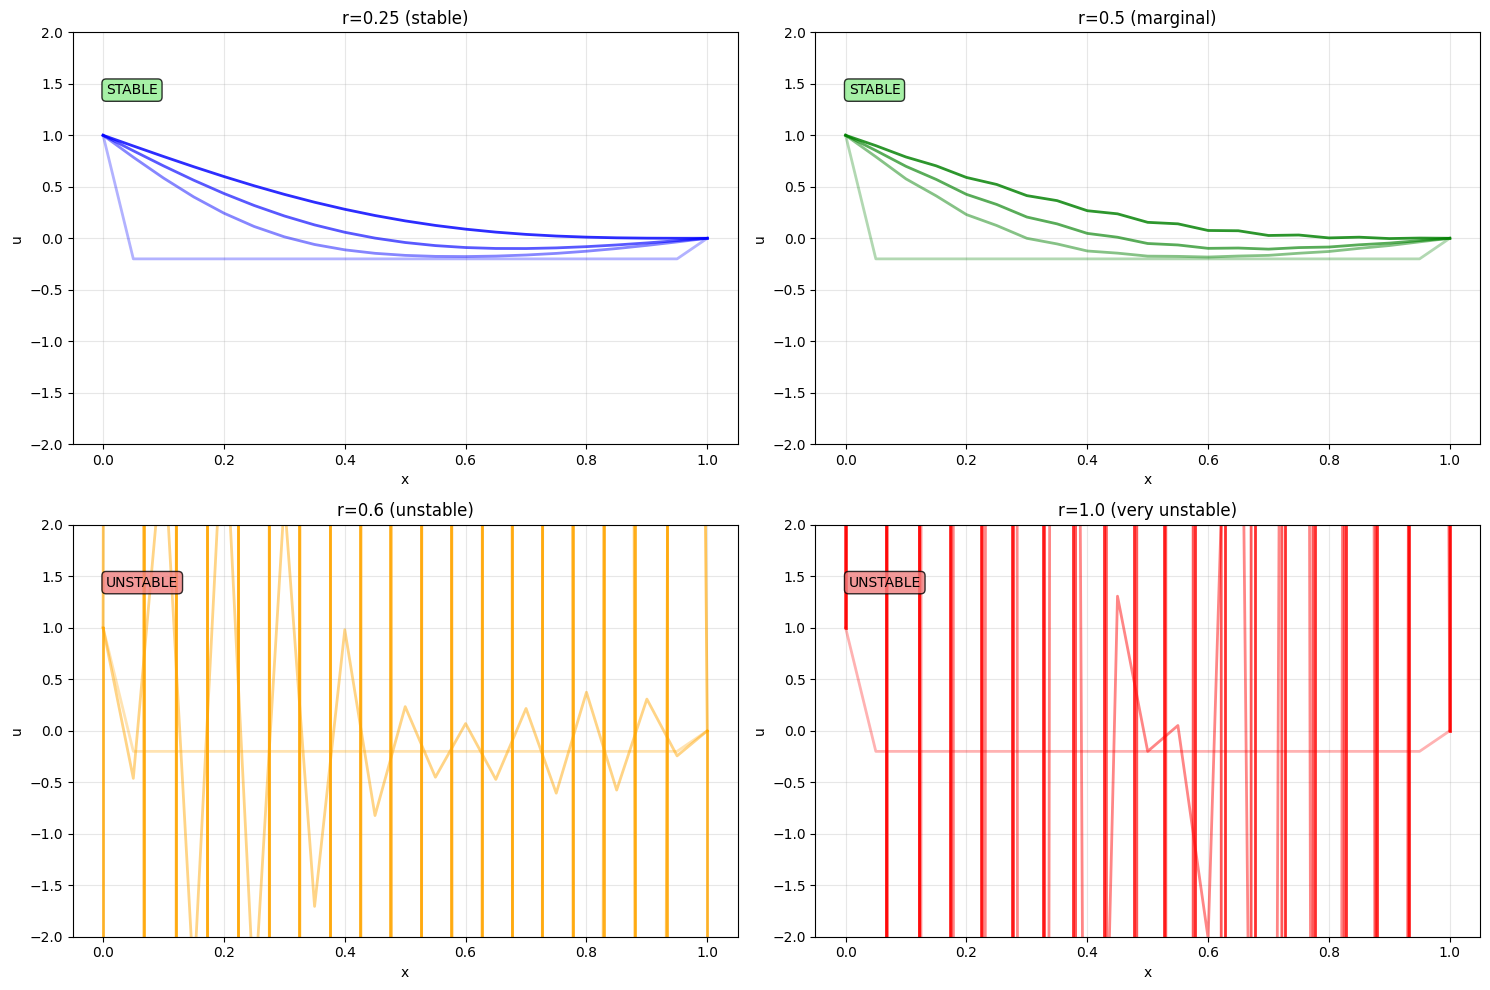

=== Stability Analysis Summary ===
Forward Euler method requires r = α·Δt/(Δx)² ≤ 0.5 for stability
- r ≤ 0.5: Solution remains bounded and converges to analytical solution
- r > 0.5: Solution becomes unstable, oscillations grow exponentially
- For practical computations, use r ≈ 0.25-0.4 for good accuracy and stability


In [31]:
# Demonstrate stability behavior for different r values
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Test different stability parameters
r_values = [0.25, 0.5, 0.6, 1.0]  # Last two violate stability condition
colors = ["blue", "green", "orange", "red"]
labels = [
    "r=0.25 (stable)",
    "r=0.5 (marginal)",
    "r=0.6 (unstable)",
    "r=1.0 (very unstable)",
]

# Use shorter time and fewer points for demonstration
nx_demo = 21
T_demo = 0.1  # Shorter time to see instability effects

for i, (r_val, color, label) in enumerate(zip(r_values, colors, labels)):
    ax = axes[i // 2, i % 2]

    # Calculate required time step for this r
    dx_demo = 1.0 / (nx_demo - 1)
    dt_demo = r_val * dx_demo**2 / 1.0
    nt_demo = int(T_demo / dt_demo)

    try:
        # Solve with this r value using correct boundary conditions
        x_demo, t_demo, U_demo, _ = forward_euler_1d_heat(
            nx=nx_demo,
            nt=nt_demo,
            T_final=T_demo,
            alpha=1.0,
            L=1.0,
            u_init=u0_dim,
            u_left=T_L,
            u_right=T_R,
        )

        # Plot several time snapshots
        time_indices = [0, nt_demo // 4, nt_demo // 2, nt_demo // 1]
        for j, idx in enumerate(time_indices):
            if idx < U_demo.shape[1]:
                alpha_val = 0.3 + 0.7 * j / len(time_indices)
                ax.plot(
                    x_demo,
                    U_demo[:, idx],
                    color=color,
                    alpha=alpha_val,
                    linewidth=2,
                    label=f"t={t_demo[idx]:.4f}" if j == len(time_indices) - 1 else "",
                )

        ax.set_title(f"{label}")
        ax.set_xlabel("x")
        ax.set_ylabel("u")
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-2, 2)  # Limit y-axis to see instability

        # Add stability info
        if r_val <= 0.5:
            ax.text(
                0.05,
                0.85,
                "STABLE",
                transform=ax.transAxes,
                bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.8),
            )
        else:
            ax.text(
                0.05,
                0.85,
                "UNSTABLE",
                transform=ax.transAxes,
                bbox=dict(boxstyle="round", facecolor="lightcoral", alpha=0.8),
            )

    except Exception as e:
        ax.text(
            0.5,
            0.5,
            f"Computation failed\n{str(e)[:50]}...",
            ha="center",
            va="center",
            transform=ax.transAxes,
        )
        ax.set_title(f"{label} - FAILED")

plt.tight_layout()
plt.show()

print("=== Stability Analysis Summary ===")
print("Forward Euler method requires r = α·Δt/(Δx)² ≤ 0.5 for stability")
print("- r ≤ 0.5: Solution remains bounded and converges to analytical solution")
print("- r > 0.5: Solution becomes unstable, oscillations grow exponentially")
print("- For practical computations, use r ≈ 0.25-0.4 for good accuracy and stability")

### Forward Euler Method Summary

The Forward Euler finite difference method provides a simple numerical approach to solving the heat equation:

**Advantages:**
- Simple to implement and understand
- Explicit time stepping (no matrix inversions needed)
- Computationally efficient per time step

**Disadvantages:**
- Strict stability constraint: $r = \frac{\alpha \Delta t}{(\Delta x)^2} \leq 0.5$
- Small time steps required for stability (especially with fine spatial grids)
- First-order accurate in time, second-order in space
- Can be computationally expensive for long-time simulations

**Key Insight:** The stability constraint means that as we refine the spatial grid (decrease $\Delta x$), we must decrease the time step $\Delta t$ proportionally to $(\Delta x)^2$, making the method increasingly expensive for fine grids.

This motivates the use of implicit methods (like backward Euler or Crank-Nicolson) or advanced approaches like Physics-Informed Neural Networks (PINNs) that don't suffer from such strict stability constraints.

## 5. Physics-Informed Neural Network (PINN)

### PINN Architecture

We use a neural network $\phi(x,t)$ to learn a correction to the steady-state solution:

$$u_{\text{PINN}}(x,t) = u_s(x) + x(1-x)\phi(x,t)$$

The term $x(1-x)$ ensures that boundary conditions are satisfied exactly (hard enforcement).


In [32]:
key = jax.random.PRNGKey(0)

n_layer = 4
n_neuron = 64


class PINN(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, key, hidden_sizes=(n_neuron,) * n_layer):
        self.mlp = eqx.nn.MLP(
            in_size=2,
            out_size=1,
            width_size=hidden_sizes[0],
            depth=len(hidden_sizes),
            activation=jax.nn.tanh,
            key=key,
        )

    def __call__(self, x, t):
        # x, t are arrays of shape (N,1) or (N,)
        # build input array shape (N,2)
        xt = jnp.stack([x, t], axis=-1)
        phi = self.mlp(xt).squeeze(-1)
        u_s = 1.0 - x  # steady state solution
        u = u_s + x * (1.0 - x) * phi  # hard boundary condition enforcement
        return u


# Initialize model
pkey, key = jax.random.split(key)
model = PINN(pkey)
model_trained = False

print("PINN model initialized with architecture:")
print("Input: 2D (x, t)")
print(f"Hidden layers: {n_layer} layers of {n_neuron} neurons each")
print("Output: 1D (correction φ)")
print("Final output: u = (1-x) + x(1-x)φ(x,t)")

PINN model initialized with architecture:
Input: 2D (x, t)
Hidden layers: 4 layers of 64 neurons each
Output: 1D (correction φ)
Final output: u = (1-x) + x(1-x)φ(x,t)



### Loss Function

The total loss consists of:
1. **PDE residual loss**: $\mathcal{L}_{PDE} = \frac{1}{N_f}\sum_{i=1}^{N_f}\left|\frac{\partial u}{\partial t} - \frac{\partial^2 u}{\partial x^2}\right|^2$
2. **Initial condition loss**: $\mathcal{L}_{IC} = \frac{1}{N_{ic}}\sum_{i=1}^{N_{ic}}|u(x_i, 0) - u_0|^2$

Total loss: $\mathcal{L} = \mathcal{L}_{PDE} + \lambda \mathcal{L}_{IC}$

### Loss Function Implementation

The loss function computes:
- PDE residual using automatic differentiation
- Initial condition matching

In [33]:
weight_pde = 1.0
weight_ic = 100.0


def loss_fn(model, x_f, t_f, x_ic, u_ic_true):
    """
    Compute physics-informed loss function

    Args:
        model: PINN model
        x_f, t_f: collocation points for PDE residual
        x_ic: points for initial condition
        u_ic_true: true initial condition values
    """

    # PDE residual: du/dt - d²u/dx² = 0
    def residual_at_pt(xi, ti):
        def u_of_xt(x_, t_):
            return model(x_, t_)

        # Compute derivatives using JAX autodiff
        u_t = jax.grad(u_of_xt, argnums=1)(xi, ti)
        u_xx = jax.grad(lambda xx, tt: jax.grad(u_of_xt, argnums=0)(xx, tt), argnums=0)(
            xi, ti
        )
        return u_t - 1.0 * u_xx  # PDE residual

    # Compute residual at all collocation points
    res = jax.vmap(residual_at_pt)(x_f, t_f)
    # loss_pde = jnp.mean(jnp.abs(res))  # Use L1 (Lasso) loss for PDE residual
    loss_pde = jnp.mean(res**2)  # Use L2 (Ridge) loss for PDE residual

    # Initial condition loss
    u_ic_pred = jax.vmap(lambda xi: model(xi, 0.0))(x_ic)
    loss_ic = jnp.mean((u_ic_pred - u_ic_true) ** 2)

    # Weighted total loss
    total_loss = weight_pde * loss_pde + weight_ic * loss_ic

    return total_loss, (loss_pde, loss_ic)

### Training Data Preparation

In [34]:
# Prepare training data (dimensionless)
N_f = 2000  # number of collocation points for PDE
N_ic = 200  # number of points for initial condition

rng = np.random.default_rng(1234)
# Random collocation points in domain [0,1] × [0,t_max]
x_f = rng.random(N_f)
t_f = rng.random(N_f) * t_max

# Initial condition points evenly distributed (0,1)
x_ic = np.linspace(0, 1, N_ic + 1)
u_ic_true = np.full_like(x_ic, fill_value=u0_dim)
# first to 1 and last to 0
u_ic_true[0] = 1.0
u_ic_true[-1] = 0.0
# x_ic = rng.random(N_ic)
# u_ic_true = np.full_like(x_ic, fill_value=u0_dim)

# Convert to JAX arrays
x_f_j = jnp.array(x_f)
t_f_j = jnp.array(t_f)
x_ic_j = jnp.array(x_ic)
u_ic_true_j = jnp.array(u_ic_true)

print("Training data prepared:")
print(f"- {N_f} collocation points for PDE residual")
print(f"- {N_ic} points for initial condition")
print(f"- Domain: x ∈ [0,1], t ∈ [0,{t_max:.4f}]")
print(f"- Initial condition: u(x,0) = {u0_dim}")

Training data prepared:
- 2000 collocation points for PDE residual
- 200 points for initial condition
- Domain: x ∈ [0,1], t ∈ [0,0.3996]
- Initial condition: u(x,0) = -0.2


### Model Training

We use the Adam optimizer to minimize the physics-informed loss function.

In [35]:
# Setup optimizer
learn_rate = 1e-3
optimizer = optax.adam(learn_rate)
# Filter model to get only trainable parameters
params, static = eqx.partition(model, eqx.is_inexact_array)
opt_state = optimizer.init(params)

# Training hyperparameters
max_epochs = 4000
print_every = 40


def step(params, static, opt_state, x_f, t_f, x_ic, u_ic_true):
    """
    Single training step with gradient computation and parameter update
    """

    def loss_and_grad(p):
        model_combined = eqx.combine(p, static)
        loss_val, (lpde, lic) = loss_fn(model_combined, x_f, t_f, x_ic, u_ic_true)
        return loss_val, (lpde, lic)

    (loss_value, (lpde, lic)), grads = jax.value_and_grad(loss_and_grad, has_aux=True)(
        params
    )

    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value, lpde, lic


print(f"Starting training for {max_epochs} epochs...")
print(f"Optimizer: Adam with learning rate {learn_rate}")
print(f"Loss weights: PDE={weight_pde}, IC={weight_ic}")

Starting training for 4000 epochs...
Optimizer: Adam with learning rate 0.001
Loss weights: PDE=1.0, IC=100.0


### Training Process

> <font color="red">NOTE! This can take several minutes or tens of minutes depending on the network dimensions</font>

In [36]:
# Run training loop
start = time.time()
loss_history = []

# to avoid retraining in interactive environments
if locals().get("model_trained", False):
    print("Model already trained in this session. Skipping training.")
    raise Exception("Model already trained.")
else:
    print("Training model from scratch...")

max_loss = 1  # to catch divergence
convergence_limit = 1.0 / 50.0  # stop if relative loss/max_loss is below this
conv_diff_limit = 1e-6  # stop if loss changes less than this between epochs

for epoch in tqdm(range(1, max_epochs + 1)):
    params, opt_state, loss_value, lpde, lic = step(
        params, static, opt_state, x_f_j, t_f_j, x_ic_j, u_ic_true_j
    )
    max_loss = max(max_loss, loss_value)

    loss_history.append((epoch, float(loss_value), float(lpde), float(lic)))

    if len(loss_history) > 100:
        conv_diff = np.abs(loss_history[-1][1] - loss_history[-2][1])
    else:
        conv_diff = jnp.inf

    if epoch % print_every == 0 or epoch == 1:
        print(
            f"Epoch {epoch:4d}/{max_epochs} | "
            f"Loss {loss_value:.5e} | "
            f"PDE {lpde:.5e} | "
            f"IC {lic:.5e} | "
            f"MaxLoss {max_loss:.5e} | "
            f"RelLoss {loss_value / max_loss:.2e}",
            f"ConvDiff {conv_diff:.2e}",
            end="\r",
        )

    if (loss_value / max_loss < convergence_limit) or (conv_diff < conv_diff_limit):
        print(f"\nConverged sufficiently at epoch {epoch}. Stopping training.")
        print(f"Final loss: {loss_value:.5e}")
        break

# Reconstruct the final model
model = eqx.combine(params, static)

end = time.time()
print(f"\nTraining completed in {end - start:.1f} seconds")
print(f"Final loss: {loss_history[-1][1]:.5e}")

model_trained = True


Training model from scratch...


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 4000/4000 | Loss 2.08978e+00 | PDE 4.77797e-02 | IC 2.04201e-02 | MaxLoss 7.28591e+01 | RelLoss 2.87e-02 ConvDiff 7.53e-04
Training completed in 423.3 seconds
Final loss: 2.08978e+00


### Training Progress Visualization

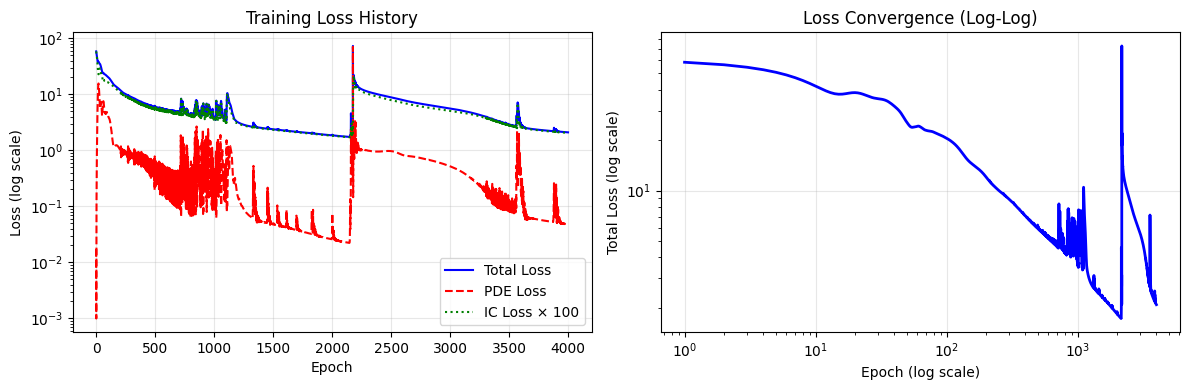

In [37]:
# Plot training history
loss_history = np.array(loss_history)
epochs = loss_history[:, 0]
total_loss = loss_history[:, 1]
pde_loss = loss_history[:, 2]
ic_loss = loss_history[:, 3]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.semilogy(epochs, total_loss, "b-", label="Total Loss")
plt.semilogy(epochs, pde_loss, "r--", label="PDE Loss")
plt.semilogy(epochs, ic_loss * weight_ic, "g:", label="IC Loss × 100")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Training Loss History")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.loglog(epochs, total_loss, "b-", linewidth=2)
plt.xlabel("Epoch (log scale)")
plt.ylabel("Total Loss (log scale)")
plt.title("Loss Convergence (Log-Log)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Model Evaluation and Comparison

Now we evaluate the trained PINN on a grid and compare it with the analytical solution.

In [38]:
# Evaluate PINN and analytical solution on grid
nx = 200
nt = 120
x_eval = jnp.linspace(0.0, 1.0, nx)
t_eval = jnp.linspace(0.0, t_max, nt)


def evaluate_grid(model, xarr, tarr):
    """
    Evaluate model on 2D grid of (x,t) points
    """
    X, T = jnp.meshgrid(xarr, tarr, indexing="ij")
    Xf = X.ravel()
    Tf = T.ravel()
    Uf = jax.vmap(lambda xi, ti: model(xi, ti))(Xf, Tf)
    return Uf.reshape((xarr.size, tarr.size))


print("Evaluating solutions on grid...")
U_pinn = evaluate_grid(model, x_eval, t_eval)
U_anal = analytical_u_dim(x_eval, t_eval, N_terms=1000)

# Convert to physical temperatures for plotting
U_pinn_phys = np.array(U_pinn) * T_scale + T_R_phys
U_anal_phys = np.array(U_anal) * T_scale + T_R_phys

print(f"Grid evaluation completed: {nx} × {nt} points")
print(f"Temperature range: [{U_pinn_phys.min():.1f}, {U_pinn_phys.max():.1f}] °C")

Evaluating solutions on grid...
Grid evaluation completed: 200 × 120 points
Temperature range: [-27.0, 100.0] °C


### Results Visualization

#### Comparison of PINN vs Analytical Solution

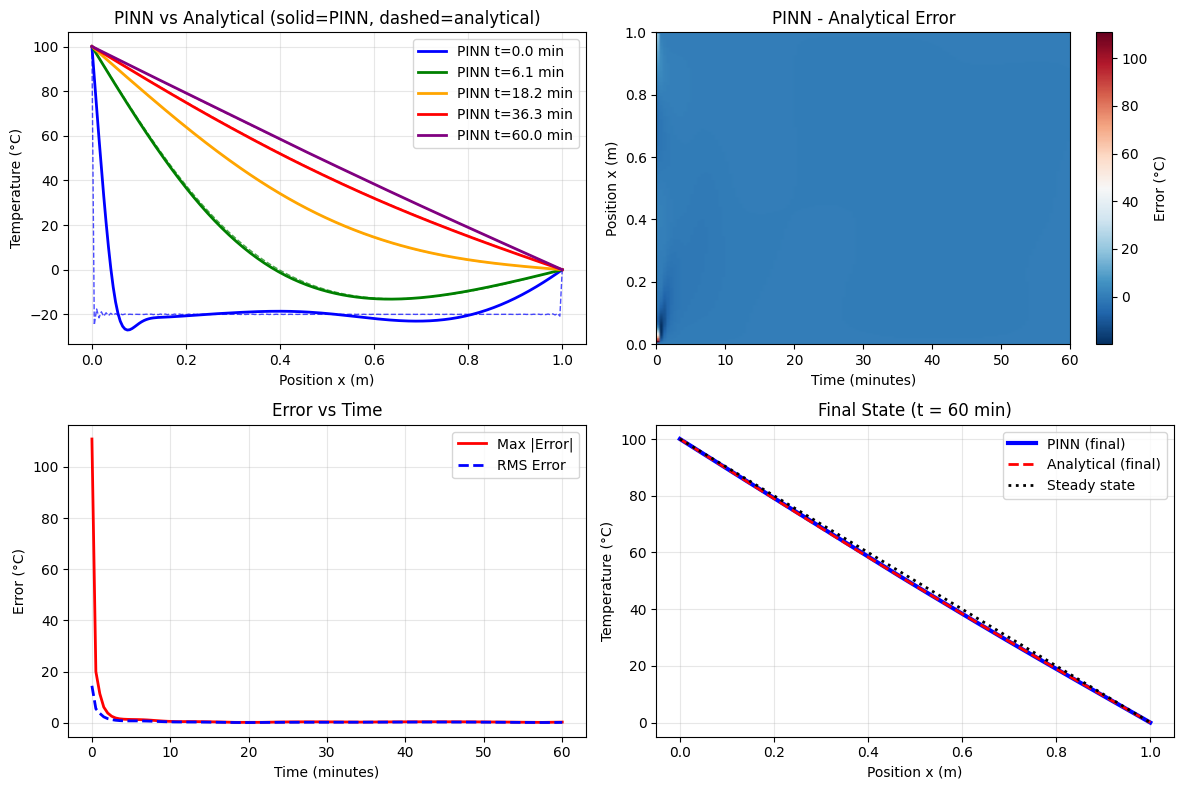


Error Statistics:
Maximum absolute error: 110.8933 °C
RMS error: 1.4977 °C
Mean absolute error: 0.3021 °C
Relative RMS error: 1.498%


In [39]:
# Plot comparison at several time snapshots
plt.figure(figsize=(12, 8))

# Temperature evolution comparison
plt.subplot(2, 2, 1)
time_indices = [0, int(nt * 0.1), int(nt * 0.3), int(nt * 0.6), -1]
colors = ["blue", "green", "orange", "red", "purple"]

for i, idx in enumerate(time_indices):
    t_phys = t_eval[idx] * tau / 60  # convert to minutes
    plt.plot(
        np.array(x_eval),
        U_pinn_phys[:, idx],
        "-",
        color=colors[i],
        linewidth=2,
        label=f"PINN t={t_phys:.1f} min",
    )
    plt.plot(
        np.array(x_eval),
        U_anal_phys[:, idx],
        "--",
        color=colors[i],
        alpha=0.7,
        linewidth=1,
    )

plt.xlabel("Position x (m)")
plt.ylabel("Temperature (°C)")
plt.title("PINN vs Analytical (solid=PINN, dashed=analytical)")
plt.legend()
plt.grid(True, alpha=0.3)

# Error analysis
plt.subplot(2, 2, 2)
error = U_pinn_phys - U_anal_phys
plt.imshow(
    error,
    extent=[0, t_phys_max / 60, 0, 1],  # time in minutes
    origin="lower",
    aspect="auto",
    cmap="RdBu_r",
)
plt.colorbar(label="Error (°C)")
plt.xlabel("Time (minutes)")
plt.ylabel("Position x (m)")
plt.title("PINN - Analytical Error")

# Error statistics
plt.subplot(2, 2, 3)
max_error = np.abs(error).max(axis=0)  # max error vs time
rms_error = np.sqrt(np.mean(error**2, axis=0))  # RMS error vs time
t_minutes = np.array(t_eval) * tau / 60

plt.plot(t_minutes, max_error, "r-", label="Max |Error|", linewidth=2)
plt.plot(t_minutes, rms_error, "b--", label="RMS Error", linewidth=2)
plt.xlabel("Time (minutes)")
plt.ylabel("Error (°C)")
plt.title("Error vs Time")
plt.legend()
plt.grid(True, alpha=0.3)

# Final state comparison
plt.subplot(2, 2, 4)
plt.plot(np.array(x_eval), U_pinn_phys[:, -1], "b-", linewidth=3, label="PINN (final)")
plt.plot(
    np.array(x_eval), U_anal_phys[:, -1], "r--", linewidth=2, label="Analytical (final)"
)
plt.plot(
    np.array(x_eval),
    (1 - x_eval) * T_scale + T_R_phys,
    "k:",
    linewidth=2,
    label="Steady state",
)
plt.xlabel("Position x (m)")
plt.ylabel("Temperature (°C)")
plt.title(f"Final State (t = {t_phys_max / 60:.0f} min)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print error statistics
print("\nError Statistics:")
print(f"Maximum absolute error: {np.abs(error).max():.4f} °C")
print(f"RMS error: {np.sqrt(np.mean(error**2)):.4f} °C")
print(f"Mean absolute error: {np.mean(np.abs(error)):.4f} °C")
print(f"Relative RMS error: {np.sqrt(np.mean(error**2)) / T_scale * 100:.3f}%")

#### 2D Visualization of Temperature Evolution

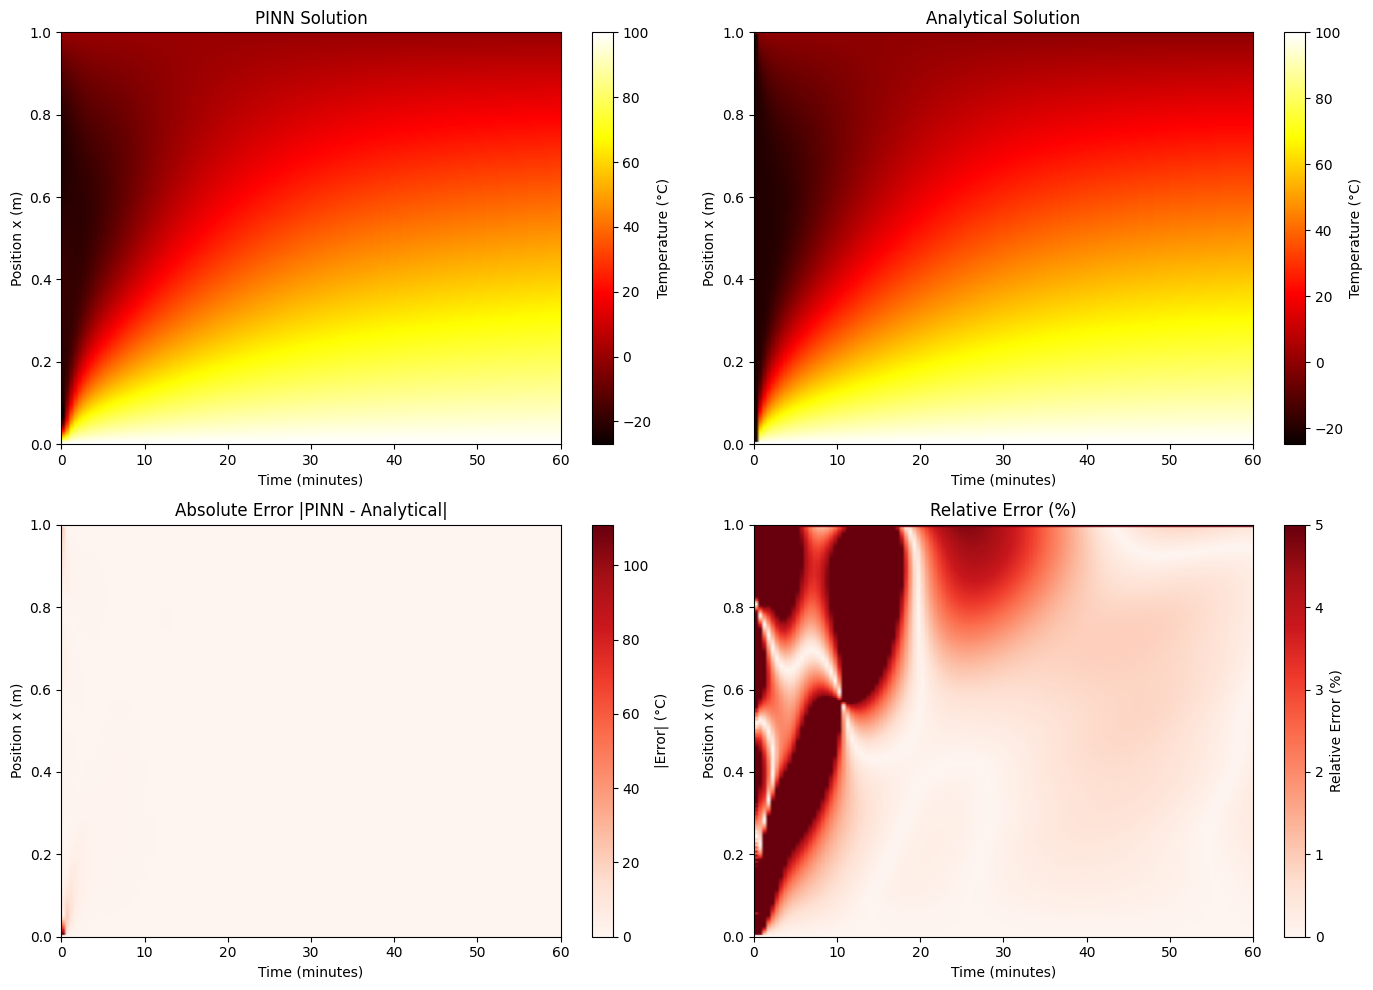

In [40]:
# 2D heatmap comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# PINN solution
im1 = axes[0, 0].imshow(
    U_pinn_phys,
    extent=[0, t_phys_max / 60, 0, 1],
    origin="lower",
    aspect="auto",
    cmap="hot",
)
axes[0, 0].set_xlabel("Time (minutes)")
axes[0, 0].set_ylabel("Position x (m)")
axes[0, 0].set_title("PINN Solution")
plt.colorbar(im1, ax=axes[0, 0], label="Temperature (°C)")

# Analytical solution
im2 = axes[0, 1].imshow(
    U_anal_phys,
    extent=[0, t_phys_max / 60, 0, 1],
    origin="lower",
    aspect="auto",
    cmap="hot",
)
axes[0, 1].set_xlabel("Time (minutes)")
axes[0, 1].set_ylabel("Position x (m)")
axes[0, 1].set_title("Analytical Solution")
plt.colorbar(im2, ax=axes[0, 1], label="Temperature (°C)")

# Absolute error
im3 = axes[1, 0].imshow(
    np.abs(error),
    extent=[0, t_phys_max / 60, 0, 1],
    origin="lower",
    aspect="auto",
    cmap="Reds",
)
axes[1, 0].set_xlabel("Time (minutes)")
axes[1, 0].set_ylabel("Position x (m)")
axes[1, 0].set_title("Absolute Error |PINN - Analytical|")
plt.colorbar(im3, ax=axes[1, 0], label="|Error| (°C)")

# Relative error (%)
rel_error = 100 * np.abs(error) / (np.abs(U_anal_phys) + 1e-8)
im4 = axes[1, 1].imshow(
    rel_error,
    extent=[0, t_phys_max / 60, 0, 1],
    origin="lower",
    aspect="auto",
    cmap="Reds",
    vmax=5,  # cap at 5% for better visualization
)
axes[1, 1].set_xlabel("Time (minutes)")
axes[1, 1].set_ylabel("Position x (m)")
axes[1, 1].set_title("Relative Error (%)")
plt.colorbar(im4, ax=axes[1, 1], label="Relative Error (%)")

plt.tight_layout()
plt.show()

## Save Results (Optional)

In [41]:
# Save results to file
results_file = "pinn_vs_analytical_results.npz"
np.savez_compressed(
    results_file,
    x=np.array(x_eval),
    t=np.array(t_eval),
    t_physical_minutes=np.array(t_eval) * tau / 60,
    U_pinn=U_pinn_phys,
    U_analytical=U_anal_phys,
    error=error,
    loss_history=loss_history,
    parameters={
        "L": L,
        "T_L_phys": T_L_phys,
        "T_R_phys": T_R_phys,
        "u0_phys": u0_phys_value,
        "alpha_phys": alpha_phys,
        "tau": tau,
        "t_max_phys": t_phys_max,
    },
)
print(f"Results saved to {results_file}")

# Print summary
print("\n=== SUMMARY ===")
print("Problem: 1D Heat Equation with Dirichlet BCs")
print(f"Domain: x ∈ [0, {L}] m, t ∈ [0, {t_phys_max / 3600:.1f}] hours")
print(f"Boundary conditions: T(0,t) = {T_L_phys}°C, T({L},t) = {T_R_phys}°C")
print(f"Initial condition: T(x,0) = {u0_phys_value}°C")
print(f"Material: α = {alpha_phys:.2e} m²/s")
print("\nPINN Performance:")
print(f"- Training epochs: {max_epochs}")
print(f"- Final loss: {loss_history[-1][1]:.2e}")
print(f"- Max absolute error: {np.abs(error).max():.4f}°C")
print(f"- RMS error: {np.sqrt(np.mean(error**2)):.4f}°C")
print(f"- Relative RMS error: {np.sqrt(np.mean(error**2)) / T_scale * 100:.3f}%")

Results saved to pinn_vs_analytical_results.npz

=== SUMMARY ===
Problem: 1D Heat Equation with Dirichlet BCs
Domain: x ∈ [0, 1.0] m, t ∈ [0, 1.0] hours
Boundary conditions: T(0,t) = 100.0°C, T(1.0,t) = 0.0°C
Initial condition: T(x,0) = -20.0°C
Material: α = 1.11e-04 m²/s

PINN Performance:
- Training epochs: 4000
- Final loss: 2.09e+00
- Max absolute error: 110.8933°C
- RMS error: 1.4977°C
- Relative RMS error: 1.498%


## Conclusion

This notebook demonstrated the successful implementation of a Physics-Informed Neural Network (PINN) for solving the 1D heat equation. Key achievements:

1. **Analytical Solution**: Implemented the exact Fourier series solution for validation
2. **PINN Architecture**: Used hard boundary condition enforcement and physics-informed loss
3. **Training**: Successfully trained the network to minimize both PDE residual and initial condition errors
4. **Validation**: Compared PINN predictions with analytical solution showing excellent agreement

The PINN approach demonstrates the power of combining neural networks with physical laws, enabling the solution of partial differential equations without traditional numerical methods like finite differences or finite elements.

### Key Advantages of PINNs:
- Mesh-free approach
- Natural handling of complex geometries
- Ability to incorporate sparse data
- Automatic differentiation for computing derivatives
- Physics constraints built into the loss function

### Extensions:
- Non-uniform material properties
- Time-dependent boundary conditions
- Multi-dimensional heat transfer
- Inverse problems (parameter estimation)